In [58]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import random 
import torch 
from tqdm import tqdm
from torch import nn 
from torch.utils.data import Dataset, DataLoader 
from sklearn.model_selection import train_test_split 
import time 
import datetime
import copy
from fbprophet import Prophet 
import sys
from transformers import AdamW, get_linear_schedule_with_warmup

In [2]:
total = pd.read_csv('한국가스공사_시간별 공급량_20181231.csv', encoding='cp949') 

total.head()

,연월일,시간,구분,공급량
0,2013-01-01,1,A,2497.129
1,2013-01-01,2,A,2363.265
2,2013-01-01,3,A,2258.505
3,2013-01-01,4,A,2243.969
4,2013-01-01,5,A,2344.105


In [3]:
d_map = {} 
for i,d in enumerate(total['구분'].unique()): 
    d_map[d] = i 

total['구분'] = total['구분'].map(d_map)

In [7]:
total['연월일'] = pd.to_datetime(total['연월일']) 

total['year'] = total['연월일'].dt.year  
total['month'] = total['연월일'].dt.month 
total['day'] = total['연월일'].dt.day 
total['weekday'] = total['연월일'].dt.weekday 

total.head(25)

,연월일,시간,구분,공급량,year,month,day,weekday
0,2013-01-01,1,0,2497.129,2013,1,1,1
1,2013-01-01,2,0,2363.265,2013,1,1,1
2,2013-01-01,3,0,2258.505,2013,1,1,1
3,2013-01-01,4,0,2243.969,2013,1,1,1
4,2013-01-01,5,0,2344.105,2013,1,1,1
5,2013-01-01,6,0,2390.961,2013,1,1,1
6,2013-01-01,7,0,2378.457,2013,1,1,1
7,2013-01-01,8,0,2518.921,2013,1,1,1
8,2013-01-01,9,0,2706.481,2013,1,1,1
9,2013-01-01,10,0,2832.057,2013,1,1,1


# Fit FBProphet

In [5]:
df0 = total[total['구분']==0] 

df0['ds'] = pd.date_range(start='1/1/2013', end='1/1/2019', freq='H')[:-1]
df0['y'] = df0['공급량']

df0 = df0[['ds','y']] 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [18]:
df0.head()

,ds,y
0,2013-01-01 00:00:00,2497.129
1,2013-01-01 01:00:00,2363.265
2,2013-01-01 02:00:00,2258.505
3,2013-01-01 03:00:00,2243.969
4,2013-01-01 04:00:00,2344.105


In [8]:
fbp = Prophet() 
fbp.fit(df0)
fut = fbp.make_future_dataframe(periods=2160, freq="1H") 
forecast = fbp.predict(fut)  

In [9]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-01 00:00:00,1456.999727,2089.001259,2694.960711,1456.999727,1456.999727,922.274890,922.274890,922.274890,-200.213567,...,60.819647,60.819647,60.819647,1061.668811,1061.668811,1061.668811,0.0,0.0,0.0,2379.274617
1,2013-01-01 01:00:00,1456.938451,1961.335731,2541.901600,1456.938451,1456.938451,804.469923,804.469923,804.469923,-317.991447,...,60.763711,60.763711,60.763711,1061.697659,1061.697659,1061.697659,0.0,0.0,0.0,2261.408374
2,2013-01-01 02:00:00,1456.877176,1867.852733,2461.160107,1456.877176,1456.877176,707.866829,707.866829,707.866829,-414.305143,...,60.443809,60.443809,60.443809,1061.728163,1061.728163,1061.728163,0.0,0.0,0.0,2164.744004
3,2013-01-01 03:00:00,1456.815900,1849.376436,2444.211579,1456.815900,1456.815900,682.715754,682.715754,682.715754,-438.932802,...,59.888226,59.888226,59.888226,1061.760329,1061.760329,1061.760329,0.0,0.0,0.0,2139.531654
4,2013-01-01 04:00:00,1456.754624,1917.345617,2523.643588,1456.754624,1456.754624,767.569189,767.569189,767.569189,-353.350976,...,59.125996,59.125996,59.125996,1061.794168,1061.794168,1061.794168,0.0,0.0,0.0,2224.323813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54739,2019-03-31 19:00:00,1191.667247,988.686838,1600.503417,1078.756495,1288.659499,111.306327,111.306327,111.306327,217.569050,...,-87.944422,-87.944422,-87.944422,-18.318301,-18.318301,-18.318301,0.0,0.0,0.0,1302.973574
54740,2019-03-31 20:00:00,1191.663656,928.117760,1621.710476,1078.660920,1288.706235,102.998036,102.998036,102.998036,202.252196,...,-80.276744,-80.276744,-80.276744,-18.977416,-18.977416,-18.977416,0.0,0.0,0.0,1294.661692
54741,2019-03-31 21:00:00,1191.660066,885.529933,1528.518071,1078.565346,1288.752972,32.920888,32.920888,32.920888,125.002827,...,-72.446731,-72.446731,-72.446731,-19.635209,-19.635209,-19.635209,0.0,0.0,0.0,1224.580954
54742,2019-03-31 22:00:00,1191.656476,783.066757,1469.381710,1078.469771,1288.799708,-63.646546,-63.646546,-63.646546,21.149614,...,-64.504474,-64.504474,-64.504474,-20.291686,-20.291686,-20.291686,0.0,0.0,0.0,1128.009930


In [11]:
yhat0 = forecast['yhat'].values[-2160:] 

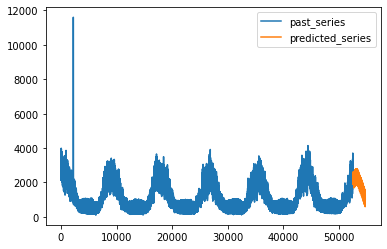

In [16]:
type0 = total[total['구분']==0]['공급량'].values

plt.plot(type0, label='past_series') 
plt.plot(np.arange(len(type0), len(type0)+len(yhat0)), yhat0, label='predicted_series') 
plt.legend()

### Type1

In [17]:
df1 = total[total['구분']==1] 

df1['ds'] = pd.date_range(start='1/1/2013', end='1/1/2019', freq='H')[:-1]
df1['y'] = df1['공급량']

df1 = df1[['ds','y']] 
df1.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,ds,y
8760,2013-01-01 00:00:00,2169.093
8761,2013-01-01 01:00:00,2051.733
8762,2013-01-01 02:00:00,1923.253
8763,2013-01-01 03:00:00,1927.253
8764,2013-01-01 04:00:00,2047.333


In [20]:
fbp = Prophet() 
fbp.fit(df1)
fut = fbp.make_future_dataframe(periods=2160, freq="1H") 
forecast1 = fbp.predict(fut)  
forecast1.tail() 

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
54739,2019-03-31 19:00:00,968.890665,839.475048,1434.588049,887.005808,1042.390298,160.037756,160.037756,160.037756,208.863819,...,-54.141849,-54.141849,-54.141849,5.315786,5.315786,5.315786,0.0,0.0,0.0,1128.928421
54740,2019-03-31 20:00:00,968.885239,832.570032,1448.791630,886.949169,1042.418744,178.414999,178.414999,178.414999,222.976761,...,-49.266815,-49.266815,-49.266815,4.705053,4.705053,4.705053,0.0,0.0,0.0,1147.300238
54741,2019-03-31 21:00:00,968.879812,813.720748,1384.862724,886.892530,1042.447190,130.779530,130.779530,130.779530,170.988312,...,-44.304435,-44.304435,-44.304435,4.095653,4.095653,4.095653,0.0,0.0,0.0,1099.659342
54742,2019-03-31 22:00:00,968.874385,719.412137,1290.696026,886.835890,1042.505776,42.812039,42.812039,42.812039,78.611419,...,-39.286963,-39.286963,-39.286963,3.487583,3.487583,3.487583,0.0,0.0,0.0,1011.686425
54743,2019-03-31 23:00:00,968.868959,619.284240,1201.933546,886.779251,1042.563011,-60.843124,-60.843124,-60.843124,-29.477491,...,-34.246471,-34.246471,-34.246471,2.880837,2.880837,2.880837,0.0,0.0,0.0,908.025834


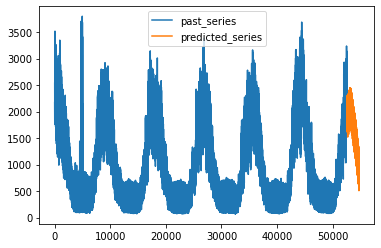

In [21]:
yhat1 = forecast1['yhat'].values[-2160:]  
type1 = total[total['구분']==1]['공급량'].values

plt.plot(type1, label='past_series') 
plt.plot(np.arange(len(type1), len(type1)+len(yhat1)), yhat1, label='predicted_series') 
plt.legend()

### type 2

In [22]:
df2 = total[total['구분']==2] 

df2['ds'] = pd.date_range(start='1/1/2013', end='1/1/2019', freq='H')[:-1]
df2['y'] = df2['공급량']

df2 = df2[['ds','y']] 
df2.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,ds,y
17520,2013-01-01 00:00:00,226.178
17521,2013-01-01 01:00:00,215.778
17522,2013-01-01 02:00:00,202.178
17523,2013-01-01 03:00:00,198.978
17524,2013-01-01 04:00:00,200.578


In [24]:
t0 = time.time() 
fbp = Prophet() 
fbp.fit(df2)
fut = fbp.make_future_dataframe(periods=2160, freq="1H") 
forecast2 = fbp.predict(fut)  
forecast2.tail() 
print(time.time() - t0)

169.61171889305115


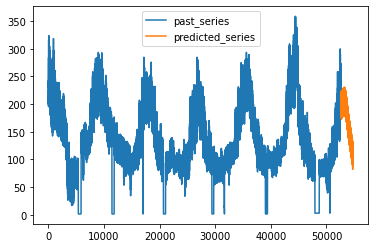

In [26]:
yhat2 = forecast2['yhat'].values[-2160:]  
type2 = total[total['구분']==2]['공급량'].values

plt.plot(type2, label='past_series') 
plt.plot(np.arange(len(type2), len(type2)+len(yhat2)), yhat2, label='predicted_series') 
plt.legend()

### type 3

In [28]:
df3 = total[total['구분']==3] 

df3['ds'] = pd.date_range(start='1/1/2013', end='1/1/2019', freq='H')[:-1]
df3['y'] = df3['공급량']

df3 = df3[['ds','y']] 
df3.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,ds,y
26280,2013-01-01 00:00:00,1434.516
26281,2013-01-01 01:00:00,1345.636
26282,2013-01-01 02:00:00,1270.756
26283,2013-01-01 03:00:00,1322.036
26284,2013-01-01 04:00:00,1421.956


In [29]:
t0 = time.time() 
fbp = Prophet() 
fbp.fit(df3)
fut = fbp.make_future_dataframe(periods=2160, freq="1H") 
forecast3 = fbp.predict(fut)  
forecast3.tail() 
print(time.time() - t0)

114.83716416358948


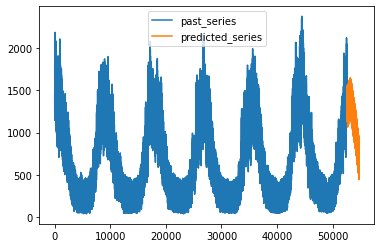

In [30]:
yhat3 = forecast3['yhat'].values[-2160:]  
type3 = total[total['구분']==3]['공급량'].values

plt.plot(type3, label='past_series') 
plt.plot(np.arange(len(type3), len(type3)+len(yhat3)), yhat3, label='predicted_series') 
plt.legend()

### type 4

In [31]:
df4 = total[total['구분']==4] 

df4['ds'] = pd.date_range(start='1/1/2013', end='1/1/2019', freq='H')[:-1]
df4['y'] = df4['공급량']

df4 = df4[['ds','y']] 
df4.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,ds,y
35040,2013-01-01 00:00:00,3272.837
35041,2013-01-01 01:00:00,3057.125
35042,2013-01-01 02:00:00,2907.765
35043,2013-01-01 03:00:00,2930.789
35044,2013-01-01 04:00:00,3067.805


In [32]:
t0 = time.time() 
fbp = Prophet() 
fbp.fit(df4)
fut = fbp.make_future_dataframe(periods=2160, freq="1H") 
forecast4 = fbp.predict(fut)  
forecast4.tail() 
print(time.time() - t0)

135.35206031799316


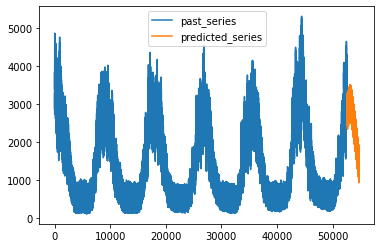

In [33]:
yhat4 = forecast4['yhat'].values[-2160:]  
type4 = total[total['구분']==4]['공급량'].values

plt.plot(type4, label='past_series') 
plt.plot(np.arange(len(type4), len(type4)+len(yhat4)), yhat4, label='predicted_series') 
plt.legend()

### type 5

In [34]:
df5 = total[total['구분']==5] 

df5['ds'] = pd.date_range(start='1/1/2013', end='1/1/2019', freq='H')[:-1]
df5['y'] = df5['공급량']

df5 = df5[['ds','y']] 
df5.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,ds,y
43800,2013-01-01 00:00:00,3560.365
43801,2013-01-01 01:00:00,3354.245
43802,2013-01-01 02:00:00,3115.757
43803,2013-01-01 03:00:00,3034.237
43804,2013-01-01 04:00:00,3050.469


In [35]:
t0 = time.time() 
fbp = Prophet() 
fbp.fit(df5)
fut = fbp.make_future_dataframe(periods=2160, freq="1H") 
forecast5 = fbp.predict(fut)  
forecast5.tail() 
print(time.time() - t0)

120.4876356124878


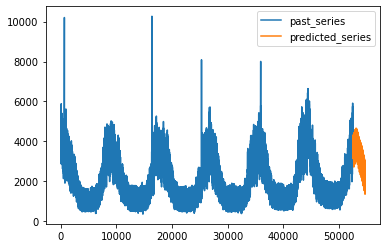

In [40]:
yhat5 = forecast5['yhat'].values[-2160:]  
type5 = total[total['구분']==5]['공급량'].values

plt.plot(type5, label='past_series') 
plt.plot(np.arange(len(type5), len(type5)+len(yhat5)), yhat5, label='predicted_series') 
plt.legend()

### type 6

In [37]:
df6 = total[total['구분']==6] 

df6['ds'] = pd.date_range(start='1/1/2013', end='1/1/2019', freq='H')[:-1]
df6['y'] = df6['공급량']

df6 = df6[['ds','y']] 
df6.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,ds,y
52560,2013-01-01 00:00:00,562.964
52561,2013-01-01 01:00:00,531.228
52562,2013-01-01 02:00:00,496.276
52563,2013-01-01 03:00:00,489.396
52564,2013-01-01 04:00:00,535.420


In [38]:
t0 = time.time() 
fbp = Prophet() 
fbp.fit(df6)
fut = fbp.make_future_dataframe(periods=2160, freq="1H") 
forecast6 = fbp.predict(fut)  
forecast6.tail() 
print(time.time() - t0)

103.2226665019989


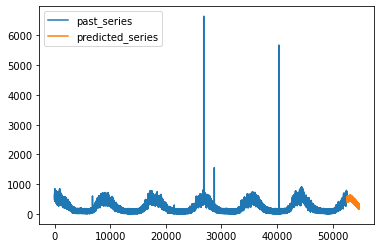

In [39]:
yhat6 = forecast6['yhat'].values[-2160:]  
type6 = total[total['구분']==6]['공급량'].values

plt.plot(type6, label='past_series') 
plt.plot(np.arange(len(type6), len(type6)+len(yhat6)), yhat6, label='predicted_series') 
plt.legend()

### final df 

In [46]:
yhat0 = yhat0.reshape((-1,1)) 
yhat1 = yhat1.reshape((-1,1)) 
yhat2 = yhat2.reshape((-1,1)) 
yhat3 = yhat3.reshape((-1,1)) 
yhat4 = yhat4.reshape((-1,1)) 
yhat5 = yhat5.reshape((-1,1)) 
yhat6 = yhat6.reshape((-1,1))

In [49]:
submission = pd.read_csv("sample_submission.csv") 

concat = np.concatenate([yhat0,yhat1,yhat2,yhat3,yhat4,yhat5,yhat6],axis=0)  

print(concat.shape)

submission.iloc[:,1] = concat  

submission.head() 

(15120, 1)


,일자|시간|구분,공급량
0,2019-01-01 01 A,2121.459034
1,2019-01-01 02 A,2003.631334
2,2019-01-01 03 A,1907.005395
3,2019-01-01 04 A,1881.831366
4,2019-01-01 05 A,1966.661736


In [50]:
neural_prophet = pd.read_csv("neural_prophet_prediction.csv") 

neural_prophet.head() 

,일자|시간|구분,공급량
0,2019-01-01 01 A,2136.023438
1,2019-01-01 02 A,1975.190796
2,2019-01-01 03 A,1907.576904
3,2019-01-01 04 A,1935.154053
4,2019-01-01 05 A,2009.003906


In [59]:
np_supplies = neural_prophet['공급량'].values 
np_supplies = np_supplies.reshape((-1,1))
np_supplies.shape

(15120, 1)

In [61]:
concat.shape, np_supplies.shape

((15120, 1), (15120, 1))

In [66]:
avg_supplies = (concat + np_supplies) / 2.0 
avg_supplies

array([[2128.74123556],
       [1989.41106498],
       [1907.29114985],
       ...,
       [ 292.53362231],
       [ 269.94429251],
       [ 245.44270696]])

In [68]:
final_submission = pd.read_csv("sample_submission.csv") 

final_submission.iloc[:,1] = avg_supplies 

final_submission.head()

,일자|시간|구분,공급량
0,2019-01-01 01 A,2128.741236
1,2019-01-01 02 A,1989.411065
2,2019-01-01 03 A,1907.291150
3,2019-01-01 04 A,1908.492709
4,2019-01-01 05 A,1987.832821


In [69]:
final_submission.to_csv("fb_prophet_neural_prophet.csv",index=False)